# Project part 2 - IRWA
[INSTRUCTIONS](https://drive.google.com/file/d/1i7nGNGLuHnrz7t9nbujGONq32AlgwyaT/view?usp=drive_link)

Bernat Quintilla - 254530

Eugeni Soler - 253566

Roger Viader - 252282

In [ ]:
from google.colab import drive
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

import pandas as pd
import numpy as np
from numpy import linalg as la
from array import array
import collections
from collections import defaultdict

import time
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm

drive.mount('/content/drive')
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 0. RECOVER

In [ ]:
# import docs and processed docs from binary files
docs_df = pd.read_pickle('/content/drive/Shareddrives/IRWA/Practica2/IRWA_data_2024/docs_df.pkl')
docs_dict = docs_df.reset_index().set_index('doc_id').T.to_dict()
docs_processed_df = pd.read_pickle('/content/drive/Shareddrives/IRWA/Practica2/IRWA_data_2024/docs_processed_df.pkl')
docs_processed = docs_processed_df.T.to_dict()

# eliminate none values and modify the format of the dictionaries
for doc_id, terms in docs_processed.items():
    final_terms = []
    for term in terms.values():
      if term is not None:
        final_terms.append(term)
    docs_processed[doc_id] = final_terms
    docs_dict[doc_id] = docs_dict[doc_id]['text']

# print to see the final format to adapt it for the practice
print(docs_processed['doc_0'])
print(docs_dict['doc_0'])

['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'shame', 'you']
The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF


In [ ]:
# Code from part 1
def build_terms(line):
    line= line.lower()
    line= line.split()
    line= [token for token in line if token not in stop_words]
    line= [token for token in line if not (token.startswith("http") or token.startswith("#") or token.startswith("@"))]
    line = ' '.join(line)
    line = re.sub(r'[^a-zA-Z\s]', ' ', line)
    line= line.split()
    line= [stemmer.stem(token) for token in line]
    return line

## 1. INDEXING

### 1.1 Build inverted index

In [ ]:
# Function from lab 1
def create_index(docs_dict, processed = True):
    index = defaultdict(list)
    inverted_index = {}
    for doc_id, doc_text in docs_dict.items():
        if not processed:
            terms = build_terms(doc_text)
        else:
            terms = doc_text

        current_page_index = {}
        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position)
            except:
                current_page_index[term]=[doc_id, array('I',[position])]

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index

inverted_index = create_index(docs_processed)


### 1.2 Propose test queries



In [ ]:
# Function from lab 1
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

In [ ]:
query_list = ["violent protest", "inflation price", "strike continuous", "human rights", "modi disaster"]
# Search
for query in query_list:
    docs = search(query, inverted_index)
    top = 5

    print("\n======================\nSample of {} results out of {} for query '{}':\n".format(top, len(docs), query))
    for d_id in docs[:top]:
        print("doc_id = {} - tweet: {}\n".format(d_id,docs_dict[d_id].replace("\n", " ")))


Sample of 5 results out of 4402 for query 'violent protest':

doc_id = doc_20712 - tweet: @ndtv God look at all these Khalistani’s causing so much disruption. These guys are probably all Congress supporters - but not a Sikh in sight. Haters will say it’s a Punjab protest #FarmersProtest #RailRokoForFarmers #RepealOnlyWayAhead 🌾❤️

doc_id = doc_22112 - tweet: Not Just the #FarmersProtest, their Propaganda unit was revealed since #demonetisation and #GST  Indians were concerned about the UNIT during #caa_nrc_npr protests  #BJP/#RSS has been applying the same late NIGHT techniques against protesters using police they applied during #CAA https://t.co/2HWc0swzwW

doc_id = doc_20458 - tweet: Protesting farmers sit on railway tracks in Sonipat after calling for a four-hour rail blockade as they continue their protest against the central government's recent #FarmLaws. #RailRoko #FarmersProtest #ITPhotoblog Photo Courtesy: Getty images https://t.co/cqn7MCplyf

doc_id = doc_41073 - tweet: Was s

### 1.3 Rank results

In [ ]:
def create_index_tfidf(docs_dict, num_documents, processed=True):
    """
    Creates an inverted index and computes tf, df, and idf.

    Arguments:
    docs_dict -- dictionary where the key is the document ID and the value is either:
                 - a raw text string (if processed=False), or
                 - a list of terms (if processed=True).
    num_documents -- total number of documents
    processed -- whether the input documents are already preprocessed (tokenized)

    Returns:
    index -- the inverted index containing terms as keys and the list of documents these terms appear in (and positions) as values.
    tf -- normalized term frequency for each term in each document
    df -- document frequency: number of documents each term appears in
    idf -- inverse document frequency for each term
    """

    index = defaultdict(list)
    tf = defaultdict(dict)
    df = defaultdict(int)
    idf = defaultdict(float)
    title_index = defaultdict(str)

    for doc_id, doc_text in docs_dict.items():
        if not processed:

            terms = build_terms(doc_text)
        else:

            terms = doc_text

        current_page_index = {}

        for position, term in enumerate(terms):
            if term in current_page_index:
                current_page_index[term][1].append(position)
            else:
                current_page_index[term] = [doc_id, array('I', [position])]

        norm = np.sqrt(sum(len(posting[1]) ** 2 for term, posting in current_page_index.items()))

        for term, posting in current_page_index.items():
            term_freq = len(posting[1]) / norm
            tf[term][doc_id] = np.round(term_freq, 4)
            df[term] += 1

        for term, posting in current_page_index.items():
            index[term].append(posting)

    for term in df:
        idf[term] = np.round(np.log(float(num_documents) / df[term]), 4)

    return index, tf, df, idf

start_time = time.time()

num_documents = len(docs_dict)
index, tf, df, idf = create_index_tfidf(docs_dict, num_documents, processed=True)

print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 25.07 seconds


In [ ]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Arguments:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and doc

    Returns:
    List of ranked document IDs, sorted by relevance score (cosine similarity).
    """

    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):
        if term not in index:
            continue

        query_vector[termIndex] = (query_terms_count[term] / query_norm) * idf.get(term, 0)

        for doc_id, postings in index[term]:
            if doc_id in docs:
                doc_vectors[doc_id][termIndex] = tf[term].get(doc_id, 0) * idf.get(term, 0)

    doc_scores = [[np.dot(doc_vec, query_vector), doc_id] for doc_id, doc_vec in doc_vectors.items()]
    doc_scores.sort(reverse=True, key=lambda x: x[0])

    ranked_docs = [doc_id for doc_id, doc_id in doc_scores]
    ranked_scores = [score for score, doc_id in doc_scores]

    if not ranked_docs:
        print("No results found. Please try again.")
        return []

    return ranked_docs, ranked_scores

In [ ]:
top = 5

for query in query_list:
    terms = query
    docs = search(query, inverted_index)
    ranked_docs, ranked_scores = rank_documents(terms, docs, index, idf, tf, docs_dict)
    print("\n======================\nSample of {} ranked results out of {} for query '{}':\n".format(top, len(ranked_docs), query))
    for d_id in ranked_docs[:top]:
        print("doc_id = {} - tweet: {}\n".format(d_id, docs_dict[d_id].replace("\n", " ")))


Sample of 5 ranked results out of 4402 for query 'violent protest':

doc_id = doc_31123 - tweet: @sunilgadavi @GanduTraveler @pranav_whatever @zoo_bear How about you read them!! Clearly people who have know why farmers are protesting #farmersprotest. https://t.co/1mmWJ8v3UY

doc_id = doc_48223 - tweet: “Those who make peaceful revolution impossible will make violent revolution inevitable.” — John F. Kennedy  #MahapanchayatRevolution #FarmersProtest https://t.co/Jxgcg1NRhN

doc_id = doc_41980 - tweet: 👇👇 Those who make peaceful revolution impossible will make violent revolution inevitable. #FarmersProtest #NoFarmersNoFood

doc_id = doc_20856 - tweet: Everyone pls Attend this protest. #FarmersProtest  #isupportfarmersprotest  #RailRokoForFarmers @Khalsa_Aid  @RaviSinghKA @ravishndtv @KhalsaAid_AU https://t.co/Ccv0EXUwbO

doc_id = doc_36931 - tweet: “Those who make peaceful revolution impossible will make violent revolution inevitable." ― John F. Kennedy  #FarmersProtest https://t.co/JRR

## 2. EVALUATION


### 2.1 Create ground truth for the documents



In [ ]:
def create_ground_truth(queries, docs_dict):
    """
    Create a ground truth dictionary for each query based on the presence of query terms in documents.

    Parameters:
    queries : list of str
        List of queries for which to create the ground truth.
    docs_dict : dict
        Dictionary where the key is the document ID and the value is the document text.

    Returns:
    dict
        A dictionary containing the ground truth for each query.
    """
    ground_truth = {}

    for query in queries:
        ground_truth[query] = {}
        query_terms = build_terms(query)

        for doc_id, doc_text in docs_dict.items():
            if any(term in doc_text.lower() for term in query_terms):
                ground_truth[query][doc_id] = 1
            else:
                ground_truth[query][doc_id] = 0

    return ground_truth

queries = ["peoples rights", "Indian Government"]
ground_truth = create_ground_truth(queries, docs_dict)


### 2.2 Use evaluation techniques


In [ ]:
y_scores = {}
ranked_docs =  {}

for query in queries:
    sum=0
    print(f"Ground truth for query '{query}': {ground_truth[query]}")
    for items in ground_truth[query].items():
      sum+=items[1]
    print(f"Number of relevant documents for query '{query}': {sum}")

    ranked_docs[query], y_scores[query] = rank_documents(query, docs, index, idf, tf, docs_dict)

def plot_metric_at_k(label:str, metric_function, k:int, start:int, step:int):
  for i in range(2):
    query = queries[i]
    if k==-1:
      k = len(ranked_docs[query])
    x, y = [], []
    for k in range(start, k, step):
      x.append(k)
      y.append(metric_function(ground_truth[query], y_scores[query], ranked_docs[query], k))

    plt.plot(x, y)
    plt.xlabel('k')
    plt.ylabel(label+' (%)')
    plt.title(label+' @ k')
    plt.legend(queries)
    plt.xlim([1, k])
    plt.ylim([0, 1])
  plt.show()

Ground truth for query 'peoples rights': {'doc_0': 0, 'doc_1': 0, 'doc_2': 0, 'doc_3': 0, 'doc_4': 0, 'doc_5': 0, 'doc_6': 0, 'doc_7': 0, 'doc_8': 0, 'doc_9': 0, 'doc_10': 0, 'doc_11': 0, 'doc_12': 0, 'doc_13': 0, 'doc_14': 0, 'doc_15': 1, 'doc_16': 0, 'doc_17': 0, 'doc_18': 0, 'doc_19': 1, 'doc_20': 1, 'doc_21': 0, 'doc_22': 0, 'doc_23': 0, 'doc_24': 0, 'doc_25': 0, 'doc_26': 0, 'doc_27': 0, 'doc_28': 0, 'doc_29': 0, 'doc_30': 0, 'doc_31': 1, 'doc_32': 0, 'doc_33': 0, 'doc_34': 0, 'doc_35': 0, 'doc_36': 0, 'doc_37': 0, 'doc_38': 1, 'doc_39': 1, 'doc_40': 0, 'doc_41': 0, 'doc_42': 0, 'doc_43': 1, 'doc_44': 0, 'doc_45': 0, 'doc_46': 1, 'doc_47': 1, 'doc_48': 0, 'doc_49': 0, 'doc_50': 0, 'doc_51': 0, 'doc_52': 0, 'doc_53': 0, 'doc_54': 0, 'doc_55': 0, 'doc_56': 0, 'doc_57': 0, 'doc_58': 0, 'doc_59': 1, 'doc_60': 0, 'doc_61': 0, 'doc_62': 0, 'doc_63': 0, 'doc_64': 0, 'doc_65': 1, 'doc_66': 0, 'doc_67': 0, 'doc_68': 0, 'doc_69': 0, 'doc_70': 0, 'doc_71': 0, 'doc_72': 1, 'doc_73': 0, 'doc_7

#### Precision @ K (P@K)

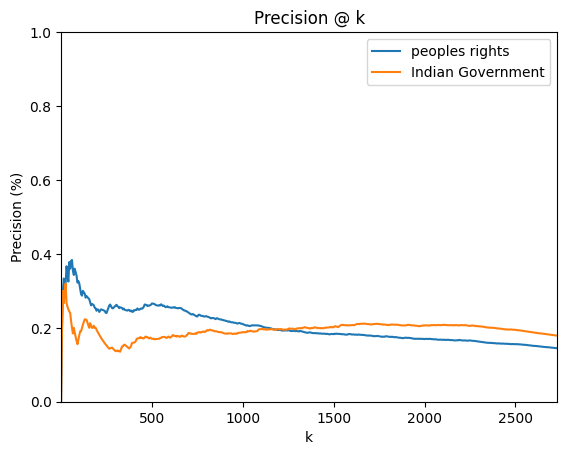

In [ ]:
def precision_at_k(ground_truth : dict, y_score : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    ground_truth: Ground truth (true relevance labels).
    y_score: Predicted scores.
    ordered_docs:  List of document ids of the scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float
    """
    relevant_at_k = 0
    for i in range(min(len(ranked_docs), k)):
      if ground_truth[ranked_docs[i]] == 1:
        relevant_at_k += 1
    if len(ranked_docs) == 0 or k==0:
      return 0.0
    return float(relevant_at_k) / min(len(ranked_docs), k)

k=-1
plot_metric_at_k('Precision',precision_at_k, k, 0, 5)

#### Recall @ K (R@K)

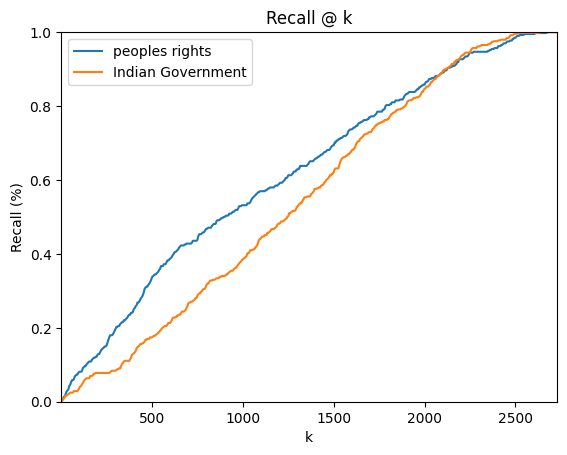

In [ ]:
def recall_at_k(ground_truth : dict, y_score : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    ground_truth: Ground truth (true relevance labels).
    y_score: Predicted scores.
    ranked_docs:  List of document ids of the scores.
    k: number of documents to consider.

    Returns
    -------
    recall @k : float

    """
    # Select the top-k documents based on the predicted scores
    relevant_at_k = 0
    total_relevant = 0
    for i in range(len(ranked_docs)):
      if ground_truth[ranked_docs[i]] == 1:
        total_relevant += 1
        if i < k:
          relevant_at_k += 1
    if total_relevant == 0:
      return 0.0
    return float(relevant_at_k) / total_relevant

k=-1
plot_metric_at_k('Recall',recall_at_k, k, 0, 5)

#### Average Precision @ K (AP@K)

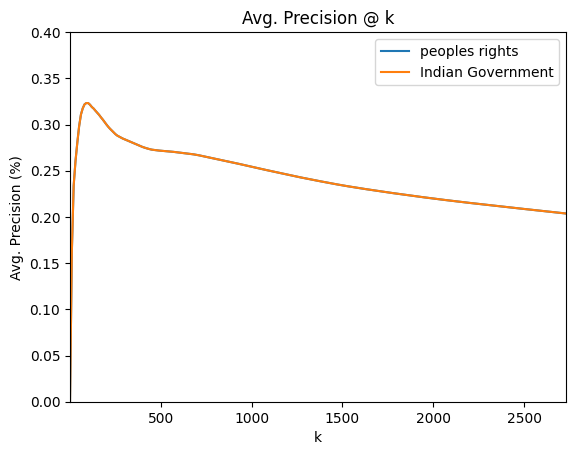

In [ ]:
def avg_precision_at_k(ground_truth : dict, y_score : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    ground_truth: Ground truth (true relevance labels).
    y_score: Predicted scores.
    ranked_docs:  List of document ids of the scores.
    k: number of documents to consider.

    Returns
    -------
    average precision @k : float
    """
    number_to_iterate = min(k, len(y_score))
    prec_at_i_list = []
    for i in range(number_to_iterate):
      prec_at_i_list.append(precision_at_k(ground_truth, y_score, ranked_docs, i+1))
    if len(prec_at_i_list) == 0:
      return 0.0
    return np.mean(prec_at_i_list)

k = len(ranked_docs[queries[0]])
prec_at_k_cache = []
for query in queries:
  k = len(ranked_docs[query])
  for i in range(k):
    prec_at_k_cache.append(precision_at_k(ground_truth[query], y_scores[query], ranked_docs[query], i))

  x, y = [], []
  for k in range(1, k, 10):
    x.append(k)
    y.append(np.mean(prec_at_k_cache[:k]))

  plt.plot(x, y)
  plt.xlabel('k')
  plt.ylabel('Avg. Precision (%)')
  plt.title('Avg. Precision @ k')
  plt.legend(queries)
  plt.xlim([1, k])
  plt.ylim([0, 0.4])
plt.show()

#### F1-score @K

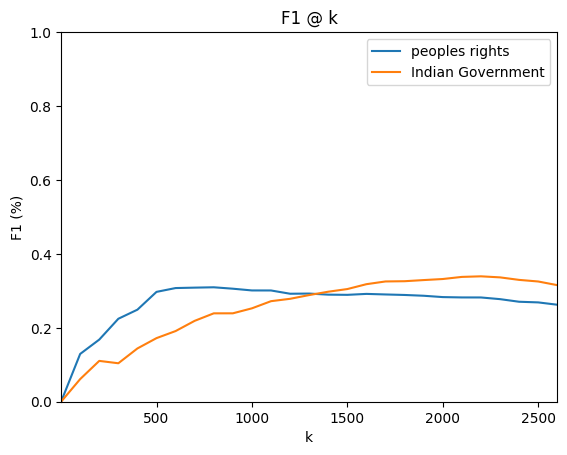

In [ ]:
def f1_at_k(ground_truth : dict, y_score : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    ground_truth: Ground truth (true relevance labels).
    y_score: Predicted scores.
    ranked_docs:  List of document ids of the scores.
    k: number of documents to consider.

    Returns
    -------
    f1 @k : float
    """
    precision = precision_at_k(ground_truth, y_score, ranked_docs, k)
    recall = recall_at_k(ground_truth, y_score, ranked_docs, k)

    if precision + recall == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

k=-1
plot_metric_at_k('F1',f1_at_k, k, 0, 100)

#### Mean Reciprocal Rank (MRR)

In [ ]:
def reciprocal_rank(ground_truth : dict, y_scores : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    doc_scores_list: List of ground truth relevance labels for each query (list of arrays).
    y_scores_list: List of predicted scores for each query (list of arrays).

    Returns
    -------
    mean reciprocal rank : float
    """
    reciprocal_rank = 0.0
    for rank, doc_id in enumerate(ranked_docs):
      if rank > k:
        break
      if ground_truth[doc_id] == 1:
        reciprocal_rank = 1.0 / (rank + 1)
        break
    return reciprocal_rank

rr = []
for query in queries:
  rr.append(reciprocal_rank(ground_truth[query], y_scores[query], ranked_docs[query]))
mean_reciprocal_rank = np.mean(rr)
print("Mean Reciprocal Rank for queries",queries,':',mean_reciprocal_rank)

Mean Reciprocal Rank for queries ['peoples rights', 'Indian Government'] : 0.225


#### Normalized Discounted Cumulative Gain (NDCG)

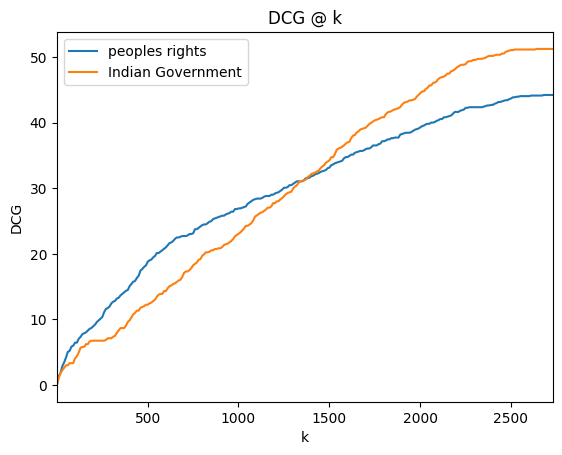

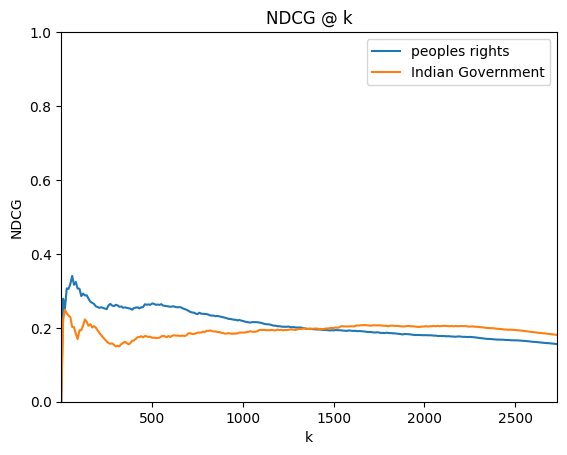

In [ ]:
def dcg_at_k(ground_truth : dict, y_score : list, ranked_docs : list, k=10):
    """
    Parameters
    ----------
    ground_truth: Ground truth (true relevance labels).
    y_score: Predicted scores.
    ordered_docs:  List of document ids of the scores.
    k : number of doc to consider.

    Returns
    -------
    DCG at rank k : list of gain @ k
    """
    gain = []
    discounted_gains = []
    for k in range(k):
      gain.append(ground_truth[ranked_docs[k]])
      discounted_gains.append((2**gain[k] - 1) / np.log2(k+2))

    return discounted_gains

def ndcg_at_k(query:str,k=10):
    """
    Parameters
    ----------
    k : number of doc to consider.
    query

    Returns
    -------
    NDCG @k : float NDCG @ k
    """
    # Compute Ideal DCG@k based on the ideal order (best possible ranking)
    cumulative_gains = np.sum(compute_gains[query][0][:k])
    ideal_cumulative_gains = np.sum(ideal_compute_gains[query][0][:k])

    return cumulative_gains/ideal_cumulative_gains if ideal_cumulative_gains != 0 else 0.0

# Compute ideal sorting (relevant at top, the rest next)
ideal_doc_sorting = {}
for query in queries:
  ideal_doc_sorting[query] = [doc_id for doc_id, gt in ground_truth[query].items() if gt == 1]
  for doc_id, gt in ground_truth[query].items():
    if gt == 0:
      ideal_doc_sorting[query].append(doc_id)

compute_gains = {}
ideal_compute_gains = {}
for query in queries:
  compute_gains[query] = []
  compute_gains[query].append(dcg_at_k(ground_truth[query], y_scores[query], ranked_docs[query], len(ranked_docs[query])))
  ideal_compute_gains[query] = []
  ideal_compute_gains[query].append(dcg_at_k(ground_truth[query], [], ideal_doc_sorting[query], len(ranked_docs[query])))

for query in queries:
  k = len(ranked_docs[query])
  x, y = [], []
  for k in range(1, k, 10):
    x.append(k)
    y.append(np.sum(compute_gains[query][0][:k]))

  plt.plot(x, y)
  plt.xlabel('k')
  plt.ylabel('DCG')
  plt.title('DCG @ k')
  plt.legend(queries)
  plt.xlim([1, k])
plt.show()

for query in queries:
  k = len(ranked_docs[query])
  x, y = [], []
  for k in range(1, k, 10):
    x.append(k)
    y.append(ndcg_at_k(query, k))

  plt.plot(x, y)
  plt.xlabel('k')
  plt.ylabel('NDCG')
  plt.title('NDCG @ k')
  plt.legend(queries)
  plt.xlim([1, k])
  plt.ylim([0, 1])
plt.show()

### 2.3 Generate a 2D vector representation of the queries and tweets

Code adapted from:
- [Visualizing Word2Vec Word Embeddings using t-SNE](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d)
- [How to run tsne on word2vec created from gensim?](https://stackoverflow.com/questions/40581010/how-to-run-tsne-on-word2vec-created-from-gensim)


In [ ]:
sentences = [terms for doc_id, terms in docs_processed.items()]
model = Word2Vec(sentences, workers=4, vector_size=100, min_count=5, window=4, sample=1e-3)


In [ ]:
keys =  ['peoples', 'rights', 'Indian','government']

embedding_clusters = []
word_clusters = []
for key in keys:
    word = build_terms(key)
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<ipython-input-21-41df9336b870>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


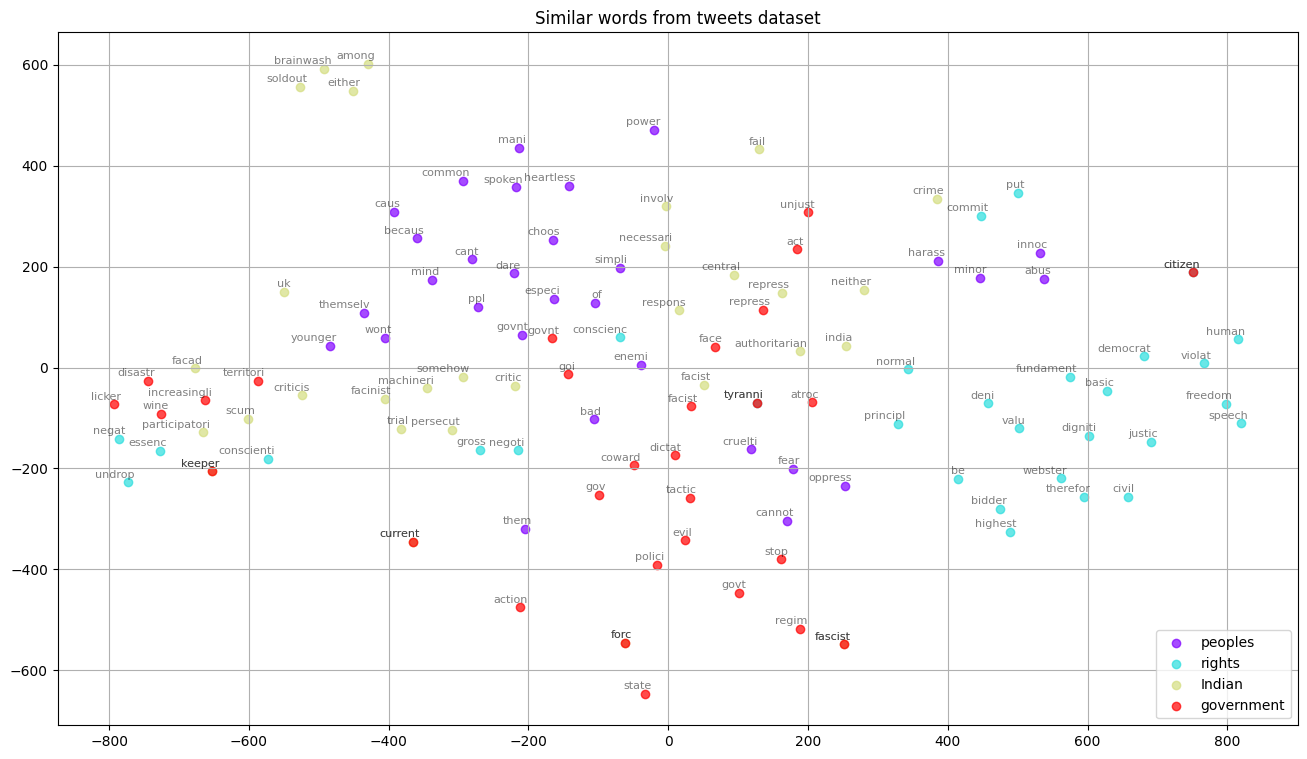

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from tweets dataset', keys, embeddings_en_2d, word_clusters, 0.7, 'similar_words.png')

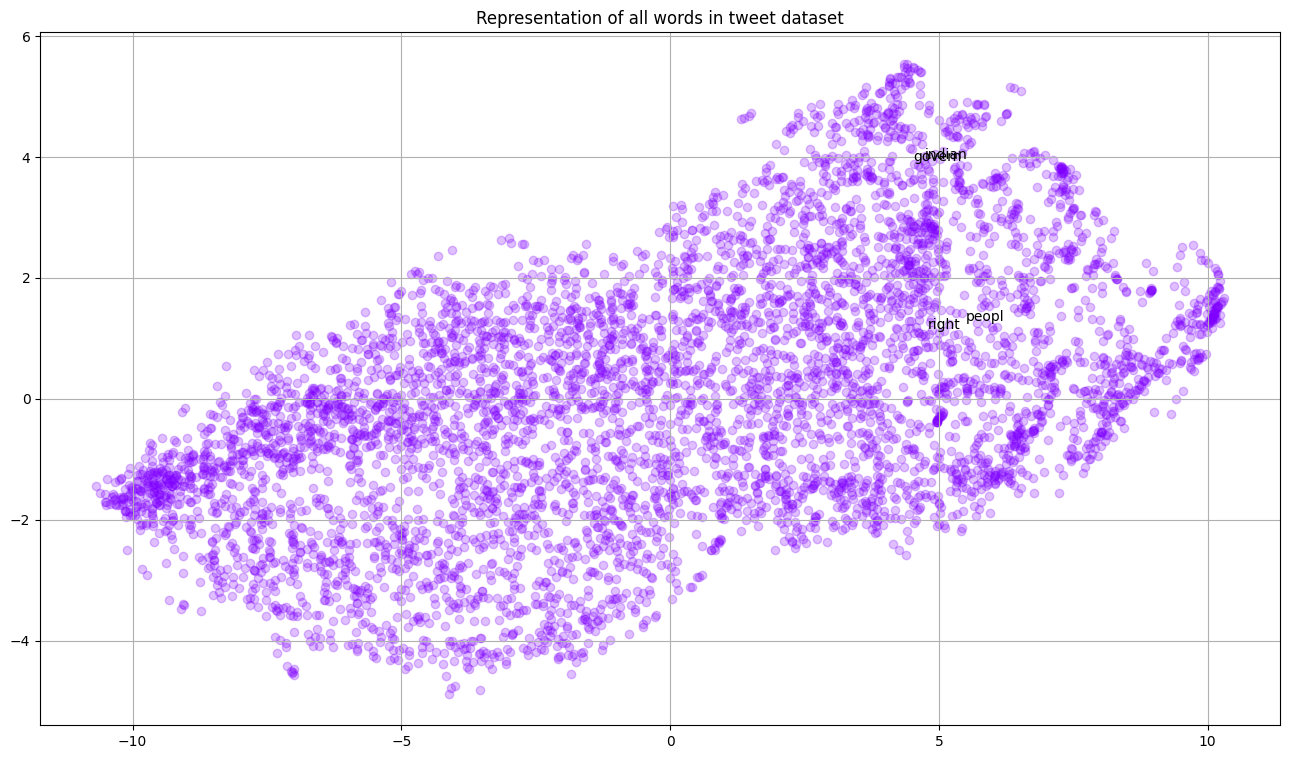

In [ ]:

words = []
embeddings = []
tweet_vocabulary = set()
for doc_id, terms in docs_processed.items():
    tweet_vocabulary.update(terms)

for word in model.wv.key_to_index:
    embeddings.append(model.wv[word])
    words.append(word)

embeddings = np.array(embeddings)
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', max_iter=300, random_state=32)
embeddings_2d = tsne_2d.fit_transform(embeddings)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=1.0, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.title(label)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

query_words = build_terms(' '.join(queries))
tsne_plot_2d('Representation of all words in tweet dataset', embeddings_2d, words=query_words, a=0.25)